# Implementing Trading with Machine Learning Regression - Part 4

In this notebook, we will use signals and compute trade details and strategy analytics

The key steps for this notebook are:
1. Import the data
2. Analyze the Performance
3. Trade Details and Strategy Analytics
4. .[Visualise the Entry and Exit](#visualise-the-entry-and-exit)
5. [Strategy_Analysis](#analysis)

In [123]:
## Import the libraries
import numpy as np 
import pandas as pd 

# For Plotting
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# To ignore unwanted warnings
import warnings
warnings.filterwarnings("ignore")

# For strategy analysis
import pyfolio as pf

### Import Data
We will import the file `regression_strategy_data.csv`. This file has predicted  high, low, signals, gold ETF returns and strategy returns.

In [124]:
strategy_data = pd.read_csv('data/strategy_data.csv', parse_dates=['Date'], index_col='Date')
strategy_data.head()

,Close,High,P_H,Low,P_L,Signal,gld_returns,strategy_returns
Date,,,,,,,,
2017-08-10,122.209999,122.440002,122.581708,122.029999,121.514771,0,NaN,NaN
2017-08-11,122.790001,122.830002,122.747055,122.029999,121.670863,-1,0.004746,0.000000
2017-08-14,121.919998,122.239998,122.504406,121.680000,121.439645,0,-0.007085,0.007085
2017-08-15,120.980003,121.230003,121.153842,120.580002,120.091055,-1,-0.007710,-0.000000
2017-08-16,121.870003,122.059998,121.240462,120.660004,120.164585,-1,0.007357,-0.007357


### Analyze the performannce

First, we will use the Sharpe ratio to analyze the performance. Later in this notebook, we will examine our strategy in detail.

#### Sharpe Ratio
Sharpe ratio is a measure for calculating risk-adjusted return. It is the ratio of the excess return (over risk-free rate) per unit of volatility or standard deviation. The formula for Sharpe Ratio is given by,

`Sharpe ratio = (sqrt(N) x mean(strategy returns - Rf)) / (std dev (Strategy returns - Rf))`

where:
- N is the number of trading days in a year
- Rf is the risk-free rate
- Std dev is standard deviation

In [125]:
# The below function returns the Sharpe ratio for the excess returns
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

# Calculate the excess daily return assuming an annual risk free rate of return of 5%
excess_daily_strategy_return = strategy_data['strategy_returns'] - 0.05/252

# Calculate the annualized sharpe ratio
sharpe = annualized_sharpe_ratio(excess_daily_strategy_return)
print('Sharpe - ', sharpe)

Sharpe -  0.1951213438453711


### Trade Details and Strategy Analytics

Trade analytics takes `data`, `Close`, and `Signal` as input parameters. And it provides us with all information regarding the number of long, short positions, gross profit, and loss using the `trades` dataframe. The synatax of the function is as follows:

    get_trades()

Parameters:
1. data: dataframe to be used for trade analysis
2. Close: Close price column of dataframe
3. Signal: Signal column of dataframe

Returns:
1. Position - long or short
2. Entry date of long or short position
3. Entry price of long or short position
4. Exit Data of long or short position
5. Exit price of long or short position

In [126]:
def get_trades(data, close_column, signal_column):
    """Function to generate trade details
    """
    # Intializing trades dataframe
    trades = pd.DataFrame()

    # There are no current positions open at the beginning
    current_position = 0

    # Creating an empty string for entry_date
    entry_date = ''

    for i in data.index:

        # Save the signal generated on date i in 'new_position'
        new_position = data.loc[i, signal_column]

        # We don't take any action if the current_position is equal to the signal generated at date i.
        # The below code will run if the signal generated is not equal to current_position.
        if new_position != current_position:

            # The below code will run if the entry_date is not empty
            if entry_date != '':

                # save entry price in entry_price
                entry_price = data.loc[entry_date, close_column]

                # Since the signal and current_position are not equal, we exit the position at date i
                exit_date = i

                # Save exit price in exit_price
                exit_price = data.loc[exit_date, close_column]

                # Create a dataframe trade_details with trade details
                trade_details = pd.DataFrame(
                    [(current_position, entry_date, entry_price, exit_date, exit_price)])

                # Update the trades dataframe in every loop
                trades = trades.append(trade_details, ignore_index=True)

                # Reset the entry_date
                entry_date = ''

            # If the new_position i.e. signal generated at i is not '0' and also not equal to current_position, we will enter either short or long trade
            if new_position != 0:

                # Save entry date of trade in entry_date
                entry_date = i

            # Update the current_position with signal generated on date i
            current_position = new_position

    # Creating below five columns in trades dataframe.
    trades.columns = ['Position', 'Entry Date',
                      'Entry Price', 'Exit Date', 'Exit Price']

    # Create a column in trades dataframe to store the profit and loss from each trade
    trades['PnL'] = (trades['Exit Price'] -
                     trades['Entry Price']) * trades['Position']

    # Returns 'trades' dataframe
    return trades

Function get analytics takes `trades` as input parameters. And it provides us with all information regarding the number of long, short positions, gross profit, and loss using the `trades` dataframe. The synatx of the function is as follow:

```python
    get_analytics()
```

Parameters:

1. Trades dataframe created using get_trades()

Returns:

1. Number of long positions
2. Number of short positions
3. Total number of trades
4. Gross profit etc

In [127]:
def get_analytics(trades):
    """Function to generate strategy analytics
    """

    analytics = pd.DataFrame(index=['Strategy'])

    # Number of long trades
    analytics['num_of_long'] = len(trades.loc[trades.Position == 1])

    # Number of short trades
    analytics['num_of_short'] = len(trades.loc[trades.Position == -1])

    # Total number of trades
    analytics['total_trades'] = analytics['num_of_long'] + analytics['num_of_short']

    # Gross Profit
    analytics['gross_profit'] =  trades.loc[trades.PnL > 0].PnL.sum()

    # Gross Loss
    analytics['gross_loss'] = trades.loc[trades.PnL < 0].PnL.sum()

    # Profitable trades
    analytics["winners"] = len(trades.loc[trades.PnL > 0])

    # Loss-making trades
    analytics['losers'] = len(trades.loc[trades.PnL <=0])

    # Win percentage
    analytics['win_percentage'] = 100*analytics["winners"]/analytics['total_trades']

    # Loss percentage
    analytics['loss_percentage'] = 100*analytics["losers"]/analytics['total_trades']

    # Per trade profit/loss of winning trades
    analytics['per_trade_PnL_winners'] = trades.loc[trades.PnL > 0].PnL.mean()

    # Per trade profit/loss of losing trades
    analytics['per_trade_PnL_losers'] = trades.loc[trades.PnL <= 0].PnL.mean()

    return analytics.T
    
    

In [128]:
# Using get_trades function to evaluate trades detail
trades = get_trades(strategy_data, 'Close', 'Signal')
print('Trade Details')

# Printing trades dataframe
trades.head()

Trade Details


,Position,Entry Date,Entry Price,Exit Date,Exit Price,PnL
0,-1,2017-08-11,122.790001,2017-08-14,121.919998,0.870003
1,-1,2017-08-15,120.980003,2017-08-17,122.489998,-1.509995
2,1,2017-08-17,122.489998,2017-08-21,122.760002,0.270004
3,1,2017-08-22,122.209999,2017-08-23,122.669998,0.459999
4,1,2017-08-25,122.739998,2017-08-28,124.690002,1.950004


<a id='visualize'></a>
### Visualise the Entry and Exit

Now we have trade details as `Entry Date`, `Entry Price` etc. We will visualize long and short entry position of clear understanding of our trading strategy

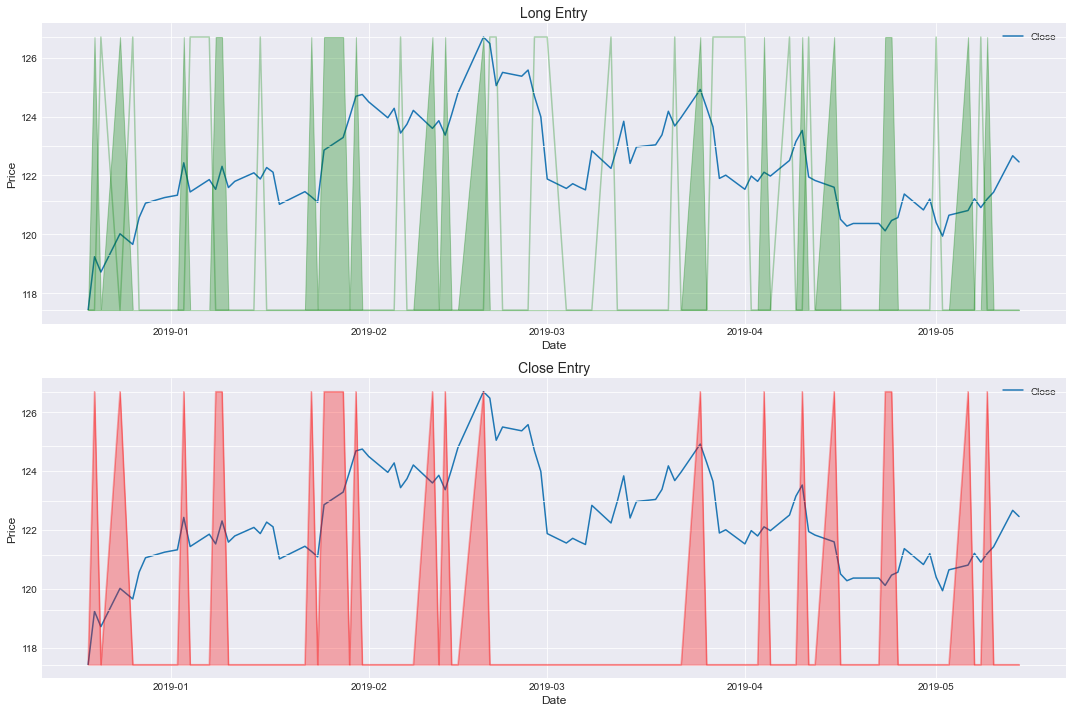

In [129]:
import matplotlib.pyplot as plt

# Showing the last 100 points for illustration purpose
test_dataset_for_plot = strategy_data[-100:]

# When signal is 1 we take long entry
test_dataset_for_plot['long_entry'] =  test_dataset_for_plot.Signal == 1

# When signal is -1 we take short entry
test_dataset_for_plot['short_entry'] = test_dataset_for_plot.Signal == -1

fig = plt.figure(figsize=(15,10))

# Sub plot for the long entry
ax = fig.add_subplot(211)

# Plotting close price
ax.plot(test_dataset_for_plot['Close'],label='Close')

# Set the title and axis label
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.set_title('Long Entry', fontsize=14)
ax.legend()

# Twinx() creates a new axes with an invisible x-axis and y-axis positioned opposite to the original one
ax2 = ax.twinx()

# Plotting long entry
ax2.plot(test_dataset_for_plot['long_entry'], color='g', alpha=0.3)
ax2.fill_between(test_dataset_for_plot['long_entry'].index, 
                test_dataset_for_plot['short_entry'].values, color='g', alpha=0.3)
ax2.tick_params(labelright=False)

# Sub plot for the short position
ax = fig.add_subplot(212)

# Sub plot for the short position
ax.plot(test_dataset_for_plot['Close'], label='Close')

# Set the title and axis label
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.set_title('Close Entry', fontsize=14)
ax.legend()

# Set the title and axis labels
ax2 = ax.twinx()
ax2.plot(test_dataset_for_plot['short_entry'], color='r', alpha=0.3)
ax2.fill_between(test_dataset_for_plot['short_entry'].index, 
                test_dataset_for_plot['short_entry'].values, color='r', alpha=0.3)
ax2.tick_params(labelright=False)

plt.tight_layout()
plt.show()

1. In both graphs, the bluw line indicates the close price of the underlying asset
2. In the first graph, you can see the green shaded region. This indicates the period where you are long on the underlying asset
3. The start of the green box will indicate the entry, and the end of the green box will show the exit from the long position
4. The second graph shows the same for the short position. The red shaded region is where we are short on the asset. And the entry and exit logic remain the same

### Trade Analytics

Trade analytics function gives us statistical information of trading profile such as number of long entries, number of short entries, etc. Now we will apply `get_analytics` function to the `trades` dataframe for trade analytics.

In [130]:
# Calling get_analytics to analyse trades
analytics = get_analytics(trades)
print('Trade Analytics')

# Rounding off to two decimal places
round(analytics,2)

Trade Analytics


,Strategy
num_of_long,80.00
num_of_short,77.00
total_trades,157.00
gross_profit,52.54
gross_loss,-39.56
winners,88.00
losers,69.00
win_percentage,56.05
loss_percentage,43.95
per_trade_PnL_winners,0.60


Few obersvations to be moted:

1. Total number of long positions are greater than that of short positions
2. `gross_profit` is greater than `gross_loss`
3. `win_percentage` is higher than `loss_percentage`

Now, we will calculate gold returns and strategy returns using previous day `Signal`

In [131]:
# Calculating closs price change percentage
strategy_data['returns'] =  strategy_data['Close'].pct_change()

# Strategy returns depends on the last day signal
strategy_data['strategy_returns'] = strategy_data['returns'] * strategy_data['Signal'].shift(1)
strategy_data.head()

,Close,High,P_H,Low,P_L,Signal,gld_returns,strategy_returns,returns
Date,,,,,,,,,
2017-08-10,122.209999,122.440002,122.581708,122.029999,121.514771,0,NaN,NaN,NaN
2017-08-11,122.790001,122.830002,122.747055,122.029999,121.670863,-1,0.004746,0.000000,0.004746
2017-08-14,121.919998,122.239998,122.504406,121.680000,121.439645,0,-0.007085,0.007085,-0.007085
2017-08-15,120.980003,121.230003,121.153842,120.580002,120.091055,-1,-0.007710,-0.000000,-0.007710
2017-08-16,121.870003,122.059998,121.240462,120.660004,120.164585,-1,0.007357,-0.007357,0.007357


<a id='analysis'></a>
### Strategy Analysis
Now we will check for NaN values in `test_dataset`, and if we find any, we will drop them

After that, we will use pyfolio library to dig into more visual details of our strategy. Pyfolio provides us details regarding backtesting in terms of annual returns, cumulative returns, sharpe ratio, etc. For more details about pyfolio, refer to [pyfolio documentation](https://quantopian.github.io/pyfolio/)

Start date,2017-08-11
End date,2019-05-14
Total months,21
,Backtest
Annual return,6.2%
Cumulative returns,11.1%
Annual volatility,6.2%
Sharpe ratio,1.00
Calmar ratio,1.27
Stability,0.68
Max drawdown,-4.9%


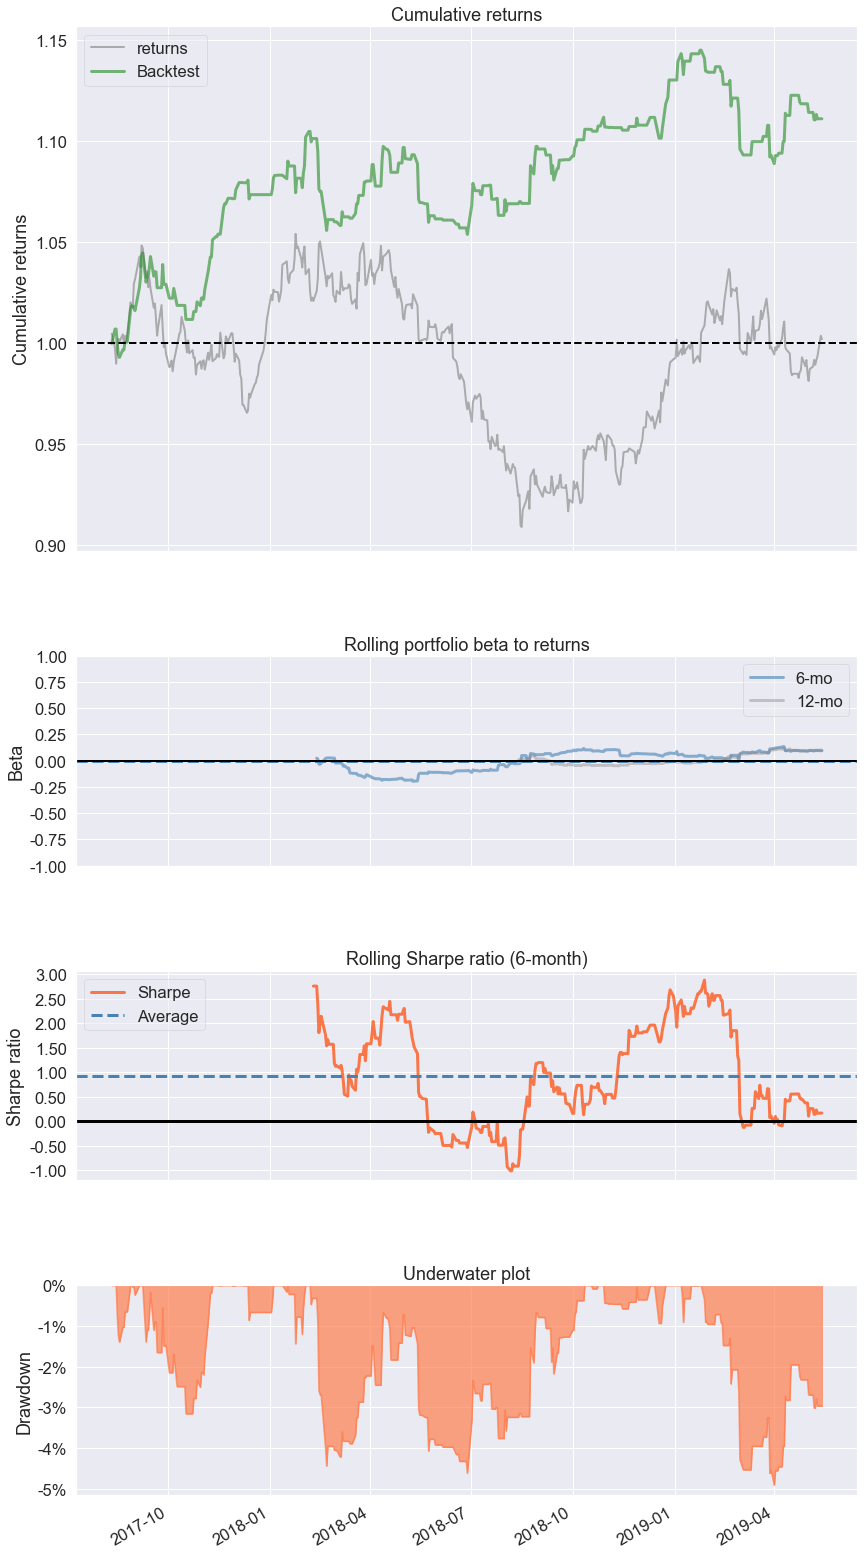

In [132]:
# Checking for NaN values
strategy_data.isna().sum(axis=1)

# Dropping the NaN values
strategy_data.dropna(inplace=True)

# Create pyfolio tear sheet
pf.create_simple_tear_sheet(strategy_data['strategy_returns'], benchmark_rets= strategy_data["returns"])


From the above plots we can conclude following points-
1. Cumulative returns show the total price return in the investment over investing period. From the first it is clear our stategy beat the benchmark cummulative return
2. Beta coefficient shows the volatility of stock price compared to a benchmark index. In the second plot, we can see the volatility of our strategy, which is very low
3. Drawdown shows down in the investment price from the peak price. Our strategy never goes down below five percent from the peak

For more details about pyfolio output terms, refer to [Performance Metric](https://blog.quantinsti.com/performance-metrics-risk-metrics-optimization/)

### Conclusion

In the last four notebooks, we learned how to implement machine learning trading using linear regression. Now , you can use different datasets or create new indicators to improve the strategy performance.